## Instalación del paquete Fenics

In [ ]:
!wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
import dolfin

## Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *
from math import sin, pi, cos

## Punto 1.a

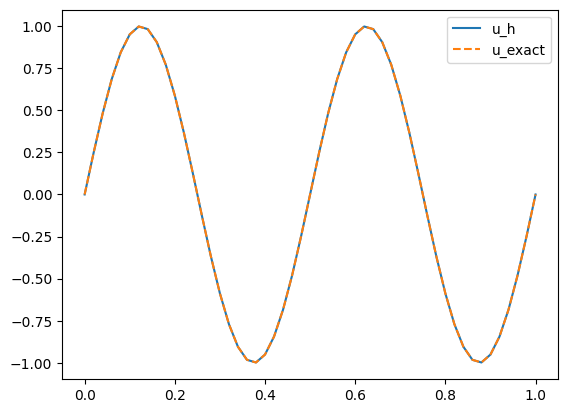

Error máximo: 4.16094657562649e-06


In [92]:
import numpy as np
import matplotlib.pyplot as plt
from fenics import *

# Crear la malla y definir el espacio de funciones
n = 50
mesh = UnitIntervalMesh(n)
V = FunctionSpace(mesh, "CG", 2)

# Definir las condiciones de contorno
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Definir el problema variacional
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("(16 * pi * pi) * sin(4 * pi * x[0])", pi=pi, degree=2)
a = dot(grad(u), grad(v)) * dx
L = f * v * dx

# Calcular la solución
u_h = Function(V)
solve(a == L, u_h, bc)

# Calcular la solución exacta
u_exact = Expression("sin(4 * pi * x[0])", degree=2)
error = np.max(np.abs(u_h.compute_vertex_values() - u_exact.compute_vertex_values(mesh)))

# Graficar la solución aproximada y la solución exacta
plot(u_h, label="u_h")
plot(interpolate(u_exact, V), linestyle="--", label="u_exact")
plt.legend()
plt.show()


print(f"Error máximo: {error}")

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from fenics import *

# Función para calcular el error L2
def calculate_error(n):
    # Crear la malla y definir el espacio de funciones
    mesh = UnitIntervalMesh(n)
    V = FunctionSpace(mesh, "CG", 2)

    # Definir las condiciones de contorno
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, Constant(0), boundary)

    # Definir el problema variacional
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Expression("(16 * pi * pi) * sin(4 * pi * x[0])", pi=pi, degree=2)
    a = dot(grad(u), grad(v)) * dx
    L = f * v * dx

    # Calcular la solución
    u_h = Function(V)
    solve(a == L, u_h, bc)

    # Calcular la solución exacta
    u_exact = Expression("sin(4 * pi * x[0])", degree=2)
    error = errornorm(u_exact, u_h, "L2")

    return error

# Valores de n a considerar
nodes_list = [5, 10, 20, 50, 100]

# Calcular errores para cada valor de n
errors = []
for n in nodes_list:
    error = calculate_error(n)
    errors.append(error)

# Imprimir la tabla de errores
print("Nodos  Error L2")
print("-" * 15)
for i in range(len(nodes_list)):
    print(f"{nodes_list[i]:<5}  {errors[i]:.5e}")


Nodos  Error L2
---------------
5      7.86943e-02
10     8.58819e-03
20     1.02613e-03
50     6.47359e-05
100    8.07482e-06


In [93]:
# Calcular errores
error_L2 = errornorm(u_exact, u_h, "L2")
#error_H1 = errornorm(u_exact, u_h, "H1")

print("Error L2:", error_L2)
#print("Error H1:", error_H1)

Error L2: 6.473588962668708e-05


## Punto 1. B

In [ ]:
import numpy as np
from fenics import *

# Parámetros del problema
T = 1.0       # Tiempo final
num_steps = 100
dt = T / num_steps
n = 20        # Número de subdivisiones en el intervalo (0, 1)

# Crear malla y función espacio
mesh = IntervalMesh(n, 0, 1)
V = FunctionSpace(mesh, "CG", 2)

# Condiciones de frontera
u_D0 = Constant(0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D0, boundary)

# Condiciones iniciales
u_n = interpolate(Constant(0), V)

# Solución exacta
u_exact = Expression("sin(4*pi*x[0])*exp(-t)", degree=2, t=0)

# Fuente
f = Expression("(-9*pow(4*pi,2)*sin(4*pi*x[0]) + sin(4*pi*x[0]))*exp(-t)", degree=2, t=0)

# Definir función de prueba
u = TrialFunction(V)
v = TestFunction(V)

# Formular el problema variacional
F = u * v * dx + dt * dot(grad(u), grad(v)) * dx - (u_n + dt * f) * v * dx
a, L = lhs(F), rhs(F)

# Preparar para guardar errores y la solución en cada paso
t = 0.0
errors = []

# Resolver el problema en cada paso de tiempo
for step in range(num_steps):
    t += dt
    
    # Actualizar la solución exacta y la fuente con el tiempo actual
    u_exact.t = t
    f.t = t
    
    # Resolver el problema variacional
    u_h = Function(V)
    solve(a == L, u_h, bc)
    
    # Calcular el error entre la solución numérica y la solución exacta
    error = np.sqrt(assemble((u_h - u_exact)**2 * dx))
    errors.append(error)
    
    # Actualizar la condición inicial con la solución actual
    u_n.assign(u_h)

# Imprimir el máximo error
print("Error máximo:", max(errors))

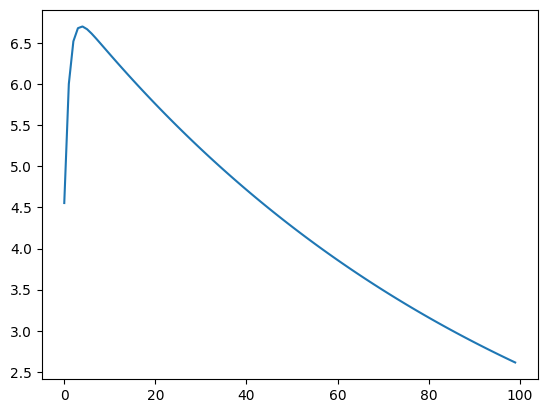

In [63]:
plt.plot(errors)

## Punto 2

In [79]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

def phi(x):
    if -1 <= x <= 0:
        return (1 + x)**2 * (1 - 2 * x)
    elif 0 <= x <= 1:
        return (1 - x)**2 * (1 + 2 * x)
    else:
        return 0

def psi(x):
    if -1 <= x <= 0:
        return x * (1 + x)**2
    elif 0 <= x <= 1:
        return x * (1 - x)**2
    else:
        return 0

def phi_i(x, i, h):
    return phi((x - i * h) / h)

def psi_i(x, i, h):
    return psi((x - i * h) / h)

# La función f(x) asociada a la solución exacta u_ex(x) = x(1-x)
def f(x):
    return -2

n = 10  # Número de elementos finitos
h = 1 / (n + 1)

# Función objetivo a minimizar: la energía potencial
def objective(u_prime_coeffs):
    energy = 0
    for i in range(n + 2):
        for j in range(n + 2):
            integral, _ = quad(lambda x: psi_i(x, i, h) * psi_i(x, j, h), 0, 1)
            energy += u_prime_coeffs[i] * u_prime_coeffs[j] * integral

    for i in range(n + 2):
        integral, _ = quad(lambda x: f(x) * psi_i(x, i, h), 0, 1)
        energy -= 2 * u_prime_coeffs[i] * integral
    return energy

# Calculamos los coeficientes u'_j
u_prime_coeffs_initial_guess = np.zeros(n + 2)
result = minimize(objective, u_prime_coeffs_initial_guess, method='L-BFGS-B')

Uprime = result.x
print("U': ", Uprime)

U':  [-26.4490009  -11.93220415  -5.36983587  -2.38737268  -0.99719903
  -0.27150358   0.27150726   0.99719835   2.38737641   5.36983301
  11.93220336  26.44899952]


In [80]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

def phi(x):
    if -1 <= x <= 0:
        return (1 + x)**2 * (1 - 2 * x)
    elif 0 <= x <= 1:
        return (1 - x)**2 * (1 + 2 * x)
    else:
        return 0

def psi(x):
    if -1 <= x <= 0:
        return x * (1 + x)**2
    elif 0 <= x <= 1:
        return x * (1 - x)**2
    else:
        return 0

def phi_i(x, i, h):
    return phi((x - i * h) / h)

def psi_i(x, i, h):
    return psi((x - i * h) / h)

def f(x):
    return -2

def u_ex(x):
    return x * (1 - x)

def get_u_prime_coeffs(n):
    h = 1 / (n + 1)
    def objective(u_prime_coeffs):
        energy = 0
        for i in range(n + 2):
            for j in range(n + 2):
                integral, _ = quad(lambda x: psi_i(x, i, h) * psi_i(x, j, h), 0, 1)
                energy += u_prime_coeffs[i] * u_prime_coeffs[j] * integral

        for i in range(n + 2):
            integral, _ = quad(lambda x: f(x) * psi_i(x, i, h), 0, 1)
            energy -= 2 * u_prime_coeffs[i] * integral
        return energy

    u_prime_coeffs_initial_guess = np.zeros(n + 2)
    result = minimize(objective, u_prime_coeffs_initial_guess, method='L-BFGS-B')

    return result.x

def u_h(x, Uprime, n):
    h = 1 / (n + 1)
    approx = 0
    for i in range(n + 2):
        approx += Uprime[i] * psi_i(x, i, h)
    return approx

def compute_error(Uprime, n):
    h = 1 / (n + 1)
    error = 0
    for i in range(n + 1):
        a, b = i * h, (i + 1) * h
        integral, _ = quad(lambda x: (u_ex(x) - u_h(x, Uprime, n))**2, a, b)
        error += integral
    return np.sqrt(error)

nodes_list = [5, 10, 20, 50, 100]
errors = []

for n in nodes_list:
    Uprime = get_u_prime_coeffs(n)
    error = compute_error(Uprime, n)
    errors.append(error)

print("Nodos  Error L_2")
print("-" * 20)
for i in range(len(nodes_list)):
    print(f"{nodes_list[i]:<5}  {errors[i]:.5e}")

<ipython-input-80-0d7334ca846b>:43: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral, _ = quad(lambda x: f(x) * psi_i(x, i, h), 0, 1)


Nodos  Error L_2
--------------------
5      1.27814e+00
10     9.45900e-01
20     6.86957e-01
50     4.54117e-01
100    3.46317e-01


## Punto 3

In [88]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parámetros del problema
n = 10
h = 1 / (n + 1)
x = np.linspace(h, 1 - h, n)

# Definición de la función f
f = x * (1 - x)

# Construcción de la matriz del sistema
diag_main = 6 * np.ones(n)
diag_sub = -4 * np.ones(n - 1)
diag_sup = np.ones(n - 2)
A = diags([diag_sub, diag_main, diag_sub[::-1], diag_sup, diag_sup[::-1]], offsets=[-1, 0, 1, 2, -2])
A = A / (h**4)

# Resolviendo el sistema lineal
u_h = spsolve(A, f)

# Comparando con la solución exacta
u_exact = x * (1 - x)
error = np.linalg.norm(u_h - u_exact)

print("Solución aproximada u_h:", u_h)
print("Solución exacta u_exact:", u_exact)
print("Error:", error)

Solución aproximada u_h: [0.00012625 0.00031667 0.0005148  0.00067436 0.0007626  0.0007626
 0.00067436 0.0005148  0.00031667 0.00012625]
Solución exacta u_exact: [0.08264463 0.14876033 0.19834711 0.23140496 0.24793388 0.24793388
 0.23140496 0.19834711 0.14876033 0.08264463]
Error: 0.603842158038218


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [91]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tabulate import tabulate

def solve_problem(n):
    h = 1 / (n + 1)
    x = np.linspace(h, 1 - h, n)

    # Definición de la función f
    f = x * (1 - x)

    # Construcción de la matriz del sistema
    diag_main = 6 * np.ones(n)
    diag_sub = -4 * np.ones(n - 1)
    diag_sup = np.ones(n - 2)
    A = diags([diag_sub, diag_main, diag_sub[::-1], diag_sup, diag_sup[::-1]], offsets=[-1, 0, 1, 2, -2])
    A = A / (h**4)

    # Resolviendo el sistema lineal
    u_h = spsolve(A, f)

    return x, u_h

def calculate_errors(x, u_h, norm_type):
    u_exact = x * (1 - x)
    
    if norm_type == "L2":
        error_norm = np.sqrt(np.sum((u_h - u_exact)**2)) / len(x)
    elif norm_type == "Linf":
        error_norm = np.max(np.abs(u_h - u_exact))
    
    return error_norm

# Valores de n a considerar
n_values = [5, 10, 20, 50, 100]
results = []

for n in n_values:
    x, u_h = solve_problem(n)
    error_l2 = calculate_errors(x, u_h, norm_type="L2")
    error_linf = calculate_errors(x, u_h, norm_type="Linf")
    results.append({"n": n, "error L2": error_l2})#, "error Linf": error_linf})

# Presentando los resultados en una tabla
print(tabulate(results, headers="keys", floatfmt=".5f"))

  n    error L2
---  ----------
  5     0.08909
 10     0.06038
 20     0.04174
 50     0.02602
100     0.01831
